# FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Download dataset from <https://github.com/mdeff/fma>.
2. Uncompress the archive, e.g. with `unzip fma_small.zip`.
3. Load and play with the data in this notebook.

In [1]:
%matplotlib inline

import utils
import librosa
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd
import os.path
import ast

In [2]:
DATA_DIR = os.environ.get('DATA_DIR')

# Load meta-data.
tracks = pd.read_csv(os.path.join(DATA_DIR, 'tracks.csv'), index_col=0, converters={'genres': ast.literal_eval})
features = pd.read_csv(os.path.join(DATA_DIR, 'features.csv'), index_col=0, header=[0, 1, 2])
echonest = pd.read_csv(os.path.join(DATA_DIR, 'echonest.csv'), index_col=0, header=[0, 1, 2])

# Construct a path() function with will retrieve the audio of any track_id.
path = utils.build_path(tracks, os.path.join(DATA_DIR, 'fma_small'))

## 1 Metadata

The metadata table, a JSON file in the root directory of the archive, is composed of many colums:
1. The index is the ID of the song, taken from the FMA, used as the name of the audio file.
2. Meta-data from the Free Music Archive website (4 columns).
3. A column to indicate if the song is part of the training or testing set.


In [3]:
ipd.display(tracks.head())

artist     genres  play_count  \
track_id                                                           
5                                    AWOL  [Hip-Hop]        1108   
134                                  AWOL  [Hip-Hop]         880   
139       Alec K. Redfearn & the Eyesores     [Folk]         490   
141       Alec K. Redfearn & the Eyesores     [Folk]         590   
142       Alec K. Redfearn & the Eyesores     [Folk]         670   

                         title top_genre train  
track_id                                        
5                   This World   Hip-Hop  True  
134               Street Music   Hip-Hop  True  
139                   CandyAss      Folk  True  
141                       Ohio      Folk  True  
142       Punjabi Watery Grave      Folk  True

## 2 Features

1. Features extracted from the audio for all tracks.
    1. MFCCs
2. For the `small` and `medium` datasets, data colected from the [Echonest](http://the.echonest.com/) API:
    1. Meta-data (5 columns).
    2. Temporal features: one vector per song.
    3. Audio features (8 columns).
    4. Social features (5 columns).
    5. Rankings (5 columns).

In [4]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 4000 tracks


In [5]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 4000 tracks


album_date      album_name  artist_latitude     artist_location  \
track_id                                                                   
5               NaN             NaN          32.6783         Georgia, US   
134             NaN             NaN          32.6783         Georgia, US   
139             NaN             NaN          41.8239  Providence, RI, US   
141             NaN             NaN          41.8239  Providence, RI, US   
142            2005  The Quiet Room          41.8239  Providence, RI, US   

          artist_longitude                        artist_name  \
track_id                                                        
5                  -83.223                               AWOL   
134                -83.223                               AWOL   
139                -71.412  Alec K. Redfearn and the Eyesores   
141                -71.412  Alec K. Redfearn and the Eyesores   
142                -71.412  Alec K. Redfearn and the Eyesores   

                        release  
track_id                         
5          AWOL - A Way Of Life  
134        AWOL - A Way Of Life  
139       Every Man For Himself  
141       Every Man For Himself  
142              The Quiet Room

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
5             0.043567      0.745566  0.701470          0.000697  0.373143   
134           0.452217      0.513238  0.560410          0.019443  0.096567   
139           0.106550      0.260911  0.607067          0.835087  0.223676   
141           0.963657      0.435933  0.075632          0.345493  0.105686   
142           0.662881      0.379065  0.823856          0.910266  0.088705   

          speechiness    tempo   valence  
track_id                                  
5            0.124595  100.260  0.621661  
134          0.525519  114.290  0.894072  
139          0.030569  196.961  0.160267  
141          0.026658   33.477  0.163950  
142          0.079090  147.781  0.092868

artist_discovery  artist_familiarity  artist_hotttnesss  \
track_id                                                            
5                 0.388990            0.386740            0.40637   
134               0.388990            0.386740            0.40637   
139               0.388923            0.330784            0.40630   
141               0.388923            0.330784            0.40630   
142               0.388923            0.330784            0.40630   

          song_currency  song_hotttnesss  
track_id                                  
5              0.000000          0.00000  
134            0.000000          0.00000  
139            0.000250          0.03855  
141            0.000167          0.03855  
142            0.000125          0.03855

artist_discovery_rank  artist_familiarity_rank  \
track_id                                                   
5                           NaN                      NaN   
134                         NaN                      NaN   
139                    149495.0                 104037.0   
141                         NaN                      NaN   
142                         NaN                      NaN   

          artist_hotttnesss_rank  song_currency_rank  song_hotttnesss_rank  
track_id                                                                    
5                            NaN                 NaN                   NaN  
134                          NaN                 NaN                   NaN  
139                     159249.0           1871529.0             5415434.0  
141                          NaN                 NaN                   NaN  
142                          NaN                 NaN                   NaN

000       001       002       003       004       005  \
track_id                                                               
5         0.548093  0.720192  0.389257  0.344934  0.361300  0.402543   
134       0.610849  0.569169  0.428494  0.345796  0.376920  0.460590   
139       0.800282  0.586372  0.354160  0.266240  0.250196  0.211132   
141       0.255494  0.185218  0.244429  0.265849  0.240221  0.400698   
142       0.331424  0.353853  0.305153  0.267472  0.338021  0.367764   

               006       007       008       009     ...           214  \
track_id                                             ...                 
5         0.434044  0.388137  0.512487  0.525755     ...     -2.288358   
134       0.401371  0.449900  0.428946  0.446736     ...     -1.452696   
139       0.287835  0.356036  0.185321  0.187473     ...     -3.078667   
141       0.215055  0.266616  0.161271  0.338353     ...     -0.457298   
142       0.419574  0.383098  0.266309  0.270089     ...     -1.125605   

                215       216      217       218      219       220       221  \
track_id                                                                        
5         11.527109  0.256821  0.23782  0.060122  0.06014   5.92649   5.86635   
134        2.356398  0.234686  0.19955  0.149332  0.06440  11.26707  11.20267   
139       12.411567  0.270802  0.27270  0.025242  0.06404   2.43669   2.37265   
141       -0.165962  0.437503  0.30739  0.368764  0.06263  11.18884  11.12621   
142        1.478418  0.215844  0.20966  0.015754  0.06921   3.91102   3.84181   

                222         223  
track_id                         
5         16.013849  356.755737  
134       26.454180  751.147705  
139        3.897095   37.866043  
141       13.481531  232.993546  
142       12.598523  346.813049  

[5 rows x 224 columns]

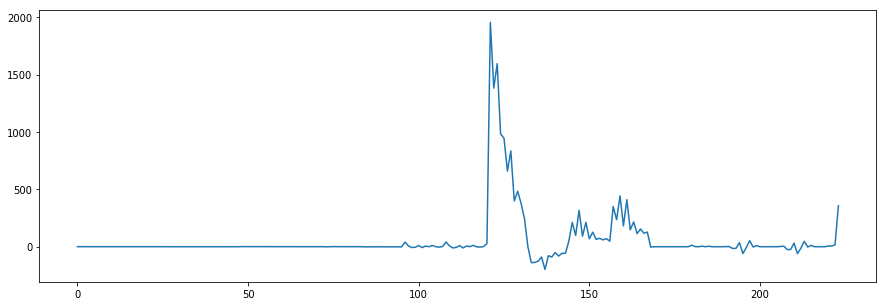

In [6]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[5, ('echonest', 'temporal_features')]
plt.figure(figsize=(15, 5))
plt.plot(x);

# 3 Audio

You can listen to an audio excerpt with the below code.

In [7]:
filename = path(0)
print('File: {}'.format(filename))
ipd.Audio(filename)

File: ../data/fma_small/Hip-Hop/5.mp3


And use [librosa](https://github.com/librosa/librosa) to extract the raw waveform and compute audio features.

Duration: 29.98s, 660984 samples


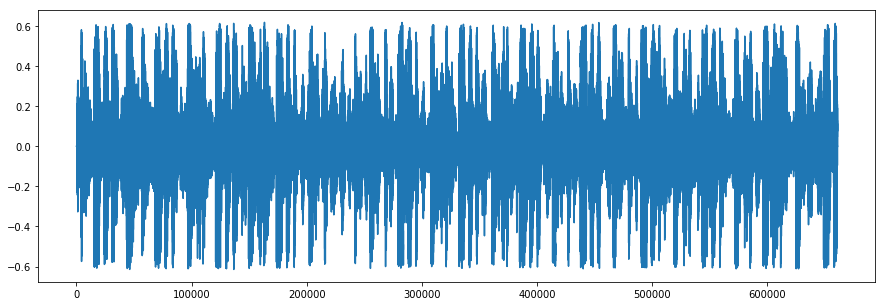

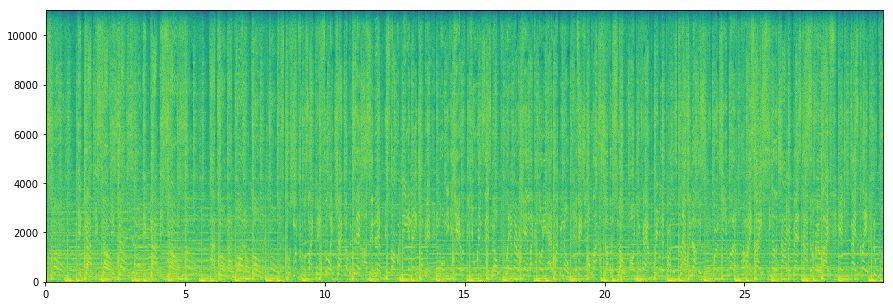

In [8]:
x, sr = librosa.load(filename)
print('Duration: {:.2f}s, {} samples'.format(x.shape[0] / sr, x.size))
ipd.display(ipd.Audio(data=x, rate=sr))

plt.figure(figsize=(15, 5))
plt.plot(x)

plt.figure(figsize=(15, 5))
S, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=sr, noverlap=512)

## 4 Genre classification

### 4.1 From features

In [9]:
# Be sure that you present the same tracks!
np.testing.assert_array_equal(features.index, tracks.index)

X = features['mfcc'].as_matrix()
y = tracks['top_genre'].as_matrix()

In [10]:
train = tracks['train'] == True

y_train = y[train]
y_test = y[~train]
X_train = X[train]
X_test = X[~train]

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

3200 training examples, 800 testing examples
140 features, 10 classes


In [11]:
# Be sure training samples are shuffled.
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2f} %'.format(score*100))

Accuracy: 41.50 %


### 4.2 From audio